## Section 1 

In [1]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr
import display_tools
from display_tools import display_da

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps, GeoData # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time as time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")

from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl

# Initial imports and setup

import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch

# Setup paths and Datacube instance
#current_dir = os.getcwd()
#tools_path = os.path.join(current_dir, "Tools")
#working_path = os.path.join(current_dir, "Working")

#sys.path.insert(1, tools_path)
#sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm

time_range = None

# Function to import display_tools.py if exists
#def import_display_tools(path):
#    if os.path.exists(path) and "display_tools.py" in os.listdir(path):
#        try:
#            from display_tools import display_da
#            print(f"display_tools module imported successfully from {path}.")
#        except ImportError as e:
#            print(f"Error importing display_tools from {path}: {e}")
#    else:
#        print(f"display_tools.py not found in {path}.")

# Function to import landcover.py if exists
#def import_landcover(path):
#    if os.path.exists(path) and "landcover.py" in os.listdir(path):
#        try:
#            from landcover import lc_colourmap, make_colorbar, plot_land_cover
#            print(f"landcover module imported successfully from {path}.")
#        except ImportError as e:
#            print(f"Error importing landcover from {path}: {e}")
#    else:
#        print(f"landcover.py not found in {path}.")

# Import modules
#import_display_tools(tools_path)
#import_display_tools(working_path)
#import_landcover(working_path)

# List files in Tools and Working
#def list_files(path):
#    if os.path.exists(path):
#        print(f"Files in {path}:")
#        print(os.listdir(path))
#    else:
#        print(f"{path} does not exist.")

#list_files(tools_path)
#list_files(working_path)

#print("Section 1: Initial imports and setup - Completed")

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Additional imports and setup
from odc.algo import xr_reproject
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from matplotlib import colors as mcolours
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry

# For DEA burn mapping
from datetime import datetime, timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

from wdc_datahandling import geopolygon_masking

added a new line here
another line


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34011/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34011/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43803,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34011/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:46025,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/46175/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:44563,


## Section 2 Select your area of interest

In [2]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


40

## Section 3  Select you

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((153.161719 -25.128351, 153.161719 -25.115296, 153.17682 -25.115296, 153.17682 -25.128351, 153.161719 -25.128351))

Selected Polygon Coordinates:
Latitude: -25.128351, Longitude: 153.161719
Latitude: -25.115296, Longitude: 153.161719
Latitude: -25.115296, Longitude: 153.17682
Latitude: -25.128351, Longitude: 153.17682
Latitude: -25.128351, Longitude: 153.161719

UTM Coordinates:
UTM X: 4962481.669025375, UTM Y: -16428586.718148733
UTM X: 4963128.633780225, UTM Y: -16430283.406611405
UTM X: 4961341.75363945, UTM Y: -16430964.415827163
UTM X: 4960695.199806821, UTM Y: -16429267.900480911
UTM X: 4962481.669025375, UTM Y: -16428586.718148733


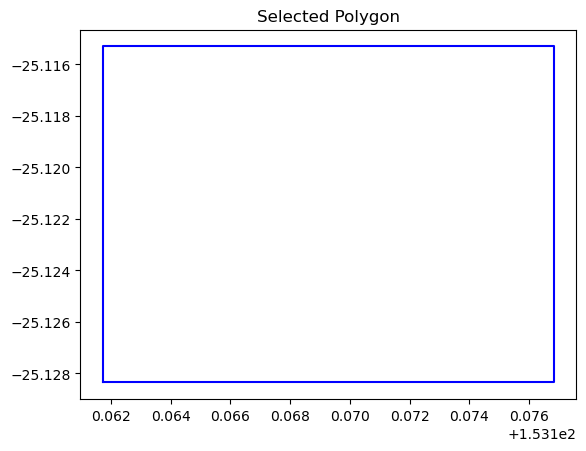

In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


## Section 4

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


## Section 5 - Load data from datacube

#### DEA Land cover

In [5]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-25.128351, -25.115296)
Lon Range: (153.161719, 153.17682)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-25.128351, -25.115296), 'x': (153.161719, 153.17682), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["

#### ESA CCI Biomass datasets (2010 and annually from 2015-2021)

In [6]:
# Step 1: Load above ground biomass datasets
AGB2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif"
AGB2015 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2015_AGBcz.tif"
AGB2016 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2016_AGBcz.tif"
AGB2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_AGBcz.tif"
AGB2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_AGBcz.tif"
AGB2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_AGBcz.tif"
AGB2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_AGBcz.tif"
AGB2021 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2021_AGBcz.tif"
SD2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_SDcz.tif"
SD2015 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2015_SDcz.tif"
SD2016 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2016_SDcz.tif"
SD2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_SDcz.tif"
SD2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_SDcz.tif"
SD2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_SDcz.tif"
SD2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_SDcz.tif"
SD2021 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2021_SDcz.tif"

# Step 2: Resample to geobox
AGB2010_prj = rio_slurp_xarray(AGB2010,lc.geobox,resampling="nearest")
AGB2015_prj = rio_slurp_xarray(AGB2015,lc.geobox,resampling="nearest")
AGB2016_prj = rio_slurp_xarray(AGB2016,lc.geobox,resampling="nearest")
AGB2017_prj = rio_slurp_xarray(AGB2017,lc.geobox,resampling="nearest")
AGB2018_prj = rio_slurp_xarray(AGB2018,lc.geobox,resampling="nearest")
AGB2019_prj = rio_slurp_xarray(AGB2019,lc.geobox,resampling="nearest")
AGB2020_prj = rio_slurp_xarray(AGB2020,lc.geobox,resampling="nearest")
AGB2021_prj = rio_slurp_xarray(AGB2021,lc.geobox,resampling="nearest")
SD2010_prj = rio_slurp_xarray(SD2010,lc.geobox,resampling="nearest")
SD2015_prj = rio_slurp_xarray(SD2015,lc.geobox,resampling="nearest")
SD2016_prj = rio_slurp_xarray(SD2016,lc.geobox,resampling="nearest")
SD2017_prj = rio_slurp_xarray(SD2017,lc.geobox,resampling="nearest")
SD2018_prj = rio_slurp_xarray(SD2018,lc.geobox,resampling="nearest")
SD2019_prj = rio_slurp_xarray(SD2019,lc.geobox,resampling="nearest")
SD2020_prj = rio_slurp_xarray(SD2020,lc.geobox,resampling="nearest")
SD2021_prj = rio_slurp_xarray(SD2021,lc.geobox,resampling="nearest")

AGB2010_prj = mask_invalid_data(AGB2010_prj)
AGB2015_prj = mask_invalid_data(AGB2015_prj)
AGB2016_prj = mask_invalid_data(AGB2016_prj)
AGB2017_prj = mask_invalid_data(AGB2017_prj)
AGB2018_prj = mask_invalid_data(AGB2018_prj)
AGB2019_prj = mask_invalid_data(AGB2019_prj)
AGB2020_prj = mask_invalid_data(AGB2020_prj)
AGB2021_prj = mask_invalid_data(AGB2021_prj)

AGB2010_prj = AGB2010_prj.where(AGB2010_prj!=0)
AGB2015_prj = AGB2015_prj.where(AGB2015_prj!=0)
AGB2016_prj = AGB2016_prj.where(AGB2016_prj!=0)
AGB2017_prj = AGB2017_prj.where(AGB2017_prj!=0)
AGB2018_prj = AGB2018_prj.where(AGB2018_prj!=0)
AGB2019_prj = AGB2019_prj.where(AGB2019_prj!=0)
AGB2020_prj = AGB2020_prj.where(AGB2020_prj!=0)
AGB2021_prj = AGB2021_prj.where(AGB2021_prj!=0)

SD2010_prj = mask_invalid_data(SD2010_prj)
SD2015_prj = mask_invalid_data(SD2015_prj)
SD2016_prj = mask_invalid_data(SD2016_prj)
SD2017_prj = mask_invalid_data(SD2017_prj)
SD2018_prj = mask_invalid_data(SD2018_prj)
SD2019_prj = mask_invalid_data(SD2019_prj)
SD2020_prj = mask_invalid_data(SD2020_prj)
SD2021_prj = mask_invalid_data(SD2021_prj)

# Step 3: Generate uncertainties based on stock differences
AGB = AGB2010_prj.to_dataset(name="AGB2010")
AGB["AGB2015"] = AGB2017_prj
AGB["AGB2016"] = AGB2018_prj
AGB["AGB2017"] = AGB2017_prj
AGB["AGB2018"] = AGB2018_prj
AGB["AGB2019"] = AGB2019_prj
AGB["AGB2020"] = AGB2020_prj
AGB["AGB2021"] = AGB2021_prj

diff2010_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2010.fillna(0))
diff2010_2015=(AGB.AGB2015.fillna(0)-AGB.AGB2010.fillna(0))
diff2015_2016=(AGB.AGB2016.fillna(0)-AGB.AGB2015.fillna(0))
diff2016_2017=(AGB.AGB2017.fillna(0)-AGB.AGB2016.fillna(0))
diff2017_2018=(AGB.AGB2018.fillna(0)-AGB.AGB2017.fillna(0))
diff2018_2019=(AGB.AGB2019.fillna(0)-AGB.AGB2018.fillna(0))
diff2019_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2019.fillna(0))
diff2020_2021=(AGB.AGB2021.fillna(0)-AGB.AGB2020.fillna(0))
diff2017_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2017.fillna(0))

diff_biomass = diff2010_2020.where(diff2010_2020!=0).to_dataset(name="d2010_2020")
diff_biomass["d2010_2015"] = diff2010_2015.where(diff2010_2015!=0)
diff_biomass["d2015_2016"] = diff2015_2016.where(diff2015_2016!=0)
diff_biomass["d2016_2017"] = diff2016_2017.where(diff2016_2017!=0)
diff_biomass["d2017_2018"] = diff2017_2018.where(diff2017_2018!=0)
diff_biomass["d2018_2019"] = diff2018_2019.where(diff2018_2019!=0)
diff_biomass["d2019_2020"] = diff2019_2020.where(diff2019_2020!=0)
diff_biomass["d2020_2021"] = diff2020_2021.where(diff2020_2021!=0)
diff_biomass["d2017_2020"] = diff2017_2020.where(diff2017_2020!=0)

SD = SD2010_prj.to_dataset(name="SD2010")
SD["SD2015"] = SD2015_prj
SD["SD2016"] = SD2016_prj
SD["SD2017"] = SD2017_prj
SD["SD2018"] = SD2018_prj
SD["SD2019"] = SD2019_prj
SD["SD2020"] = SD2020_prj
SD["SD2021"] = SD2021_prj

del AGB2010, AGB2015, AGB2016, AGB2017, AGB2018, AGB2019, AGB2020, AGB2021, SD2010, SD2015, SD2016, SD2017, SD2018, SD2019, SD2020, SD2021

AGB2010_Min = AGB.AGB2010-SD.SD2010
AGB2010_Max = AGB.AGB2010+SD.SD2010
AGB2015_Min = AGB.AGB2015-SD.SD2015
AGB2015_Max = AGB.AGB2015+SD.SD2015
AGB2016_Min = AGB.AGB2016-SD.SD2016
AGB2016_Max = AGB.AGB2016+SD.SD2016
AGB2017_Min = AGB.AGB2017-SD.SD2017
AGB2017_Max = AGB.AGB2017+SD.SD2017
AGB2018_Min = AGB.AGB2018-SD.SD2018
AGB2018_Max = AGB.AGB2018+SD.SD2018
AGB2019_Min = AGB.AGB2019-SD.SD2019
AGB2019_Max = AGB.AGB2019+SD.SD2019
AGB2020_Min = AGB.AGB2020-SD.SD2020
AGB2020_Max = AGB.AGB2020+SD.SD2020
AGB2021_Min = AGB.AGB2021-SD.SD2021
AGB2021_Max = AGB.AGB2021+SD.SD2021

min_biomass = AGB2010_Min.to_dataset(name="AGB2010_Min")
min_biomass["AGB2015_Min"] = AGB2015_Min
min_biomass["AGB2016_Min"] = AGB2016_Min
min_biomass["AGB2017_Min"] = AGB2017_Min
min_biomass["AGB2018_Min"] = AGB2018_Min
min_biomass["AGB2019_Min"] = AGB2019_Min
min_biomass["AGB2020_Min"] = AGB2020_Min
min_biomass["AGB2021_Min"] = AGB2021_Min

del AGB2010_Min, AGB2015_Min, AGB2016_Min, AGB2017_Min, AGB2018_Min, AGB2019_Min, AGB2020_Min,  AGB2021_Min

max_biomass = AGB2010_Max.to_dataset(name="AGB2010_Max")
max_biomass["AGB2015_Max"] = AGB2015_Max
max_biomass["AGB2016_Max"] = AGB2016_Max
max_biomass["AGB2017_Max"] = AGB2017_Max
max_biomass["AGB2018_Max"] = AGB2018_Max
max_biomass["AGB2019_Max"] = AGB2019_Max
max_biomass["AGB2020_Max"] = AGB2020_Max
max_biomass["AGB2021_Max"] = AGB2021_Max

del AGB2010_Max, AGB2015_Max, AGB2016_Max, AGB2017_Max, AGB2018_Max, AGB2019_Max, AGB2020_Max, AGB2021_Max

cond_dec_2010_2020 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2010_2015 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2015_Max.fillna(0)
cond_dec_2015_2016 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2016_Max.fillna(0)
cond_dec_2016_2017 = min_biomass.AGB2016_Min.fillna(0) > max_biomass.AGB2017_Max.fillna(0)
cond_dec_2017_2018 = min_biomass.AGB2017_Min.fillna(0) > max_biomass.AGB2018_Max.fillna(0)
cond_dec_2018_2019 = min_biomass.AGB2018_Min.fillna(0) > max_biomass.AGB2019_Max.fillna(0)
cond_dec_2019_2020 = min_biomass.AGB2019_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2020_2021 = min_biomass.AGB2020_Min.fillna(0) > max_biomass.AGB2021_Max.fillna(0)
cond_dec_2017_2020 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)

cond_inc_2010_2020 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2010_2015 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2015_Min.fillna(0)
cond_inc_2015_2016 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2016_Min.fillna(0)
cond_inc_2016_2017 = max_biomass.AGB2016_Max.fillna(0) < min_biomass.AGB2017_Min.fillna(0)
cond_inc_2017_2018 = max_biomass.AGB2017_Max.fillna(0) < min_biomass.AGB2018_Min.fillna(0)
cond_inc_2018_2019 = max_biomass.AGB2018_Max.fillna(0) < min_biomass.AGB2019_Min.fillna(0)
cond_inc_2019_2020 = max_biomass.AGB2019_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2020_2021 = max_biomass.AGB2020_Max.fillna(0) < min_biomass.AGB2021_Min.fillna(0)
cond_inc_2017_2020 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)

agb_sc = cond_dec_2010_2020.to_dataset(name="cond_dec_2010_2020") 
agb_sc["cond_dec_2010_2015"] = cond_dec_2010_2015
agb_sc["cond_dec_2015_2016"] = cond_dec_2015_2016
agb_sc["cond_dec_2016_2017"] = cond_dec_2016_2017
agb_sc["cond_dec_2017_2018"] = cond_dec_2017_2018
agb_sc["cond_dec_2018_2019"] = cond_dec_2018_2019 
agb_sc["cond_dec_2019_2020"] = cond_dec_2019_2020 
agb_sc["cond_dec_2020_2021"] = cond_dec_2020_2021 
agb_sc["cond_dec_2017_2020"] = cond_dec_2017_2020 

agb_sc = cond_inc_2010_2020.to_dataset(name="cond_inc_2010_2020") 
agb_sc["cond_inc_2010_2015"] = cond_inc_2010_2015
agb_sc["cond_inc_2015_2016"] = cond_inc_2015_2016
agb_sc["cond_inc_2016_2017"] = cond_inc_2016_2017
agb_sc["cond_inc_2017_2018"] = cond_inc_2017_2018
agb_sc["cond_inc_2018_2019"] = cond_inc_2018_2019 
agb_sc["cond_inc_2019_2020"] = cond_inc_2019_2020 
agb_sc["cond_inc_2020_2021"] = cond_inc_2020_2021 
agb_sc["cond_inc_2017_2020"] = cond_inc_2017_2020 

## Section 6:  View datasets

In [7]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

In [8]:
bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))
#norm = mpl.colors.Normalize(vmin=2, vmax=200)
#norm(0)

[49 100]


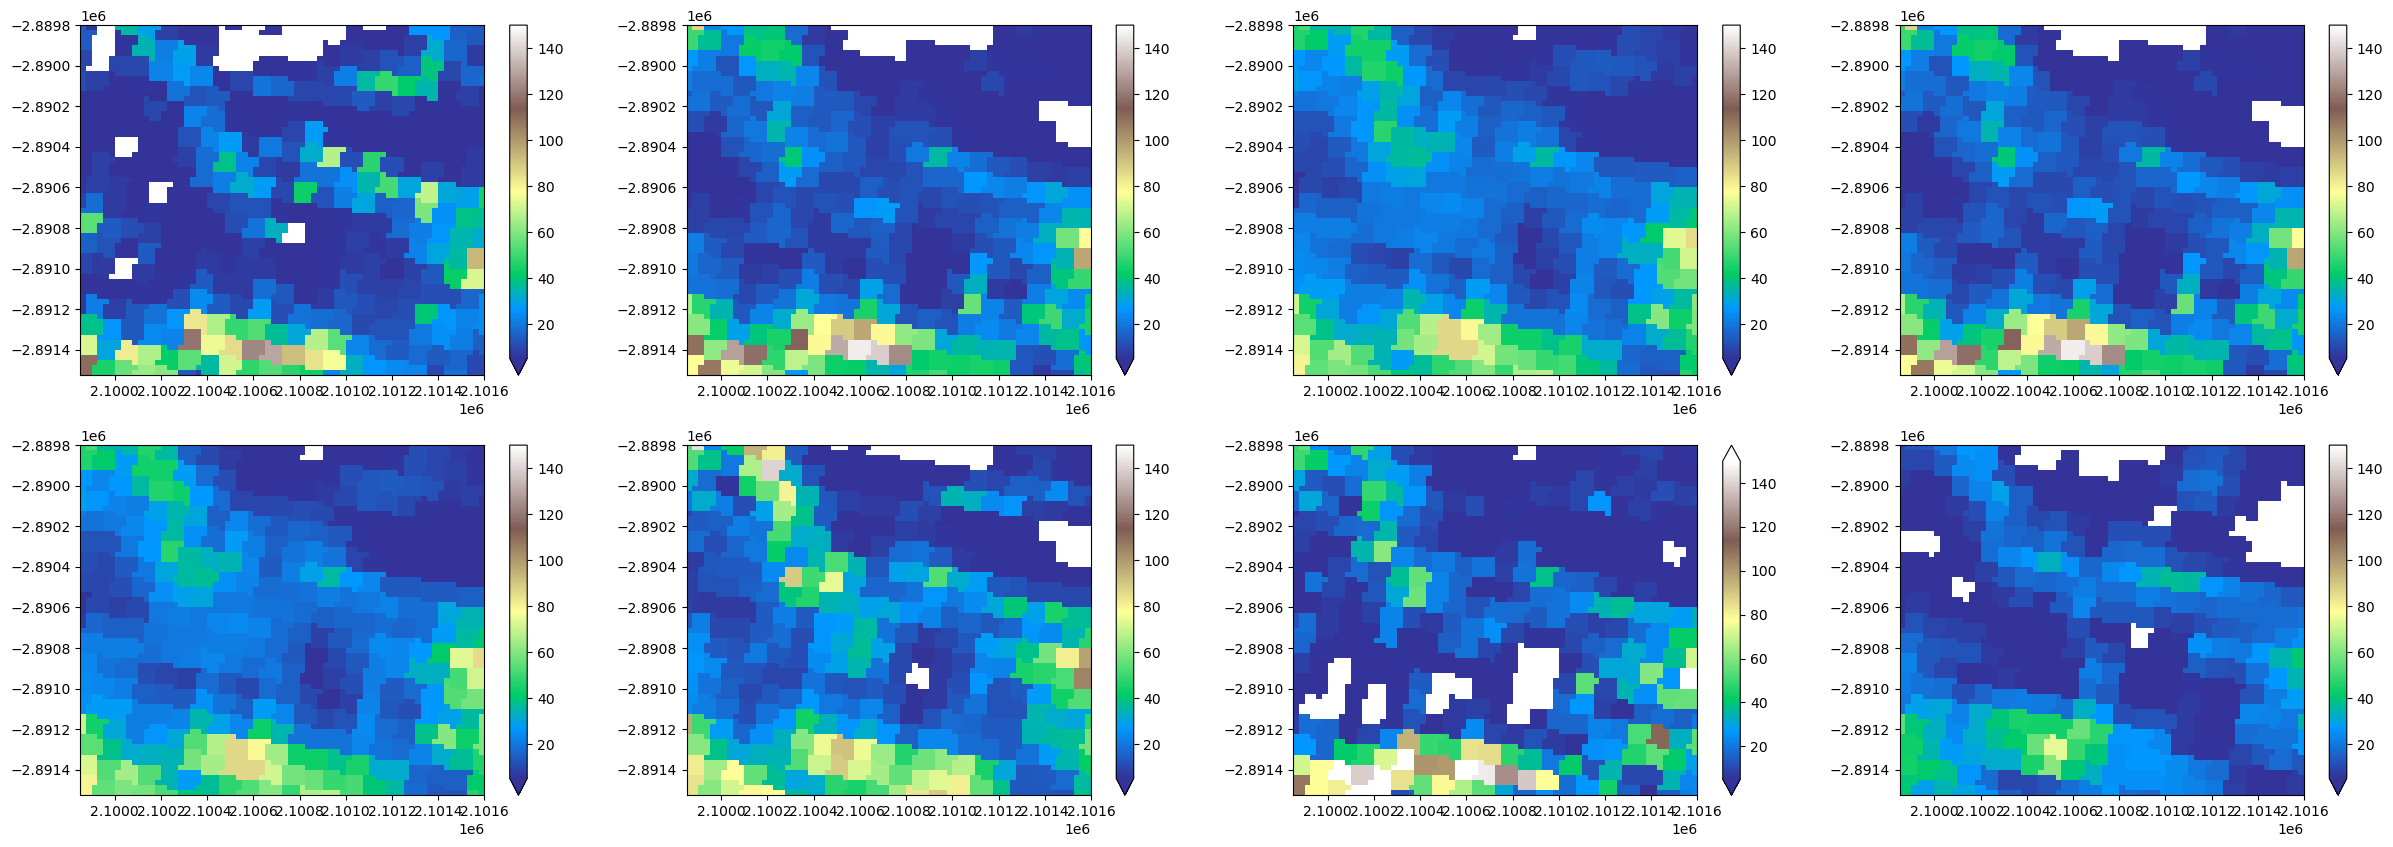

In [9]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)

2024-08-13 12:02:01,746 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


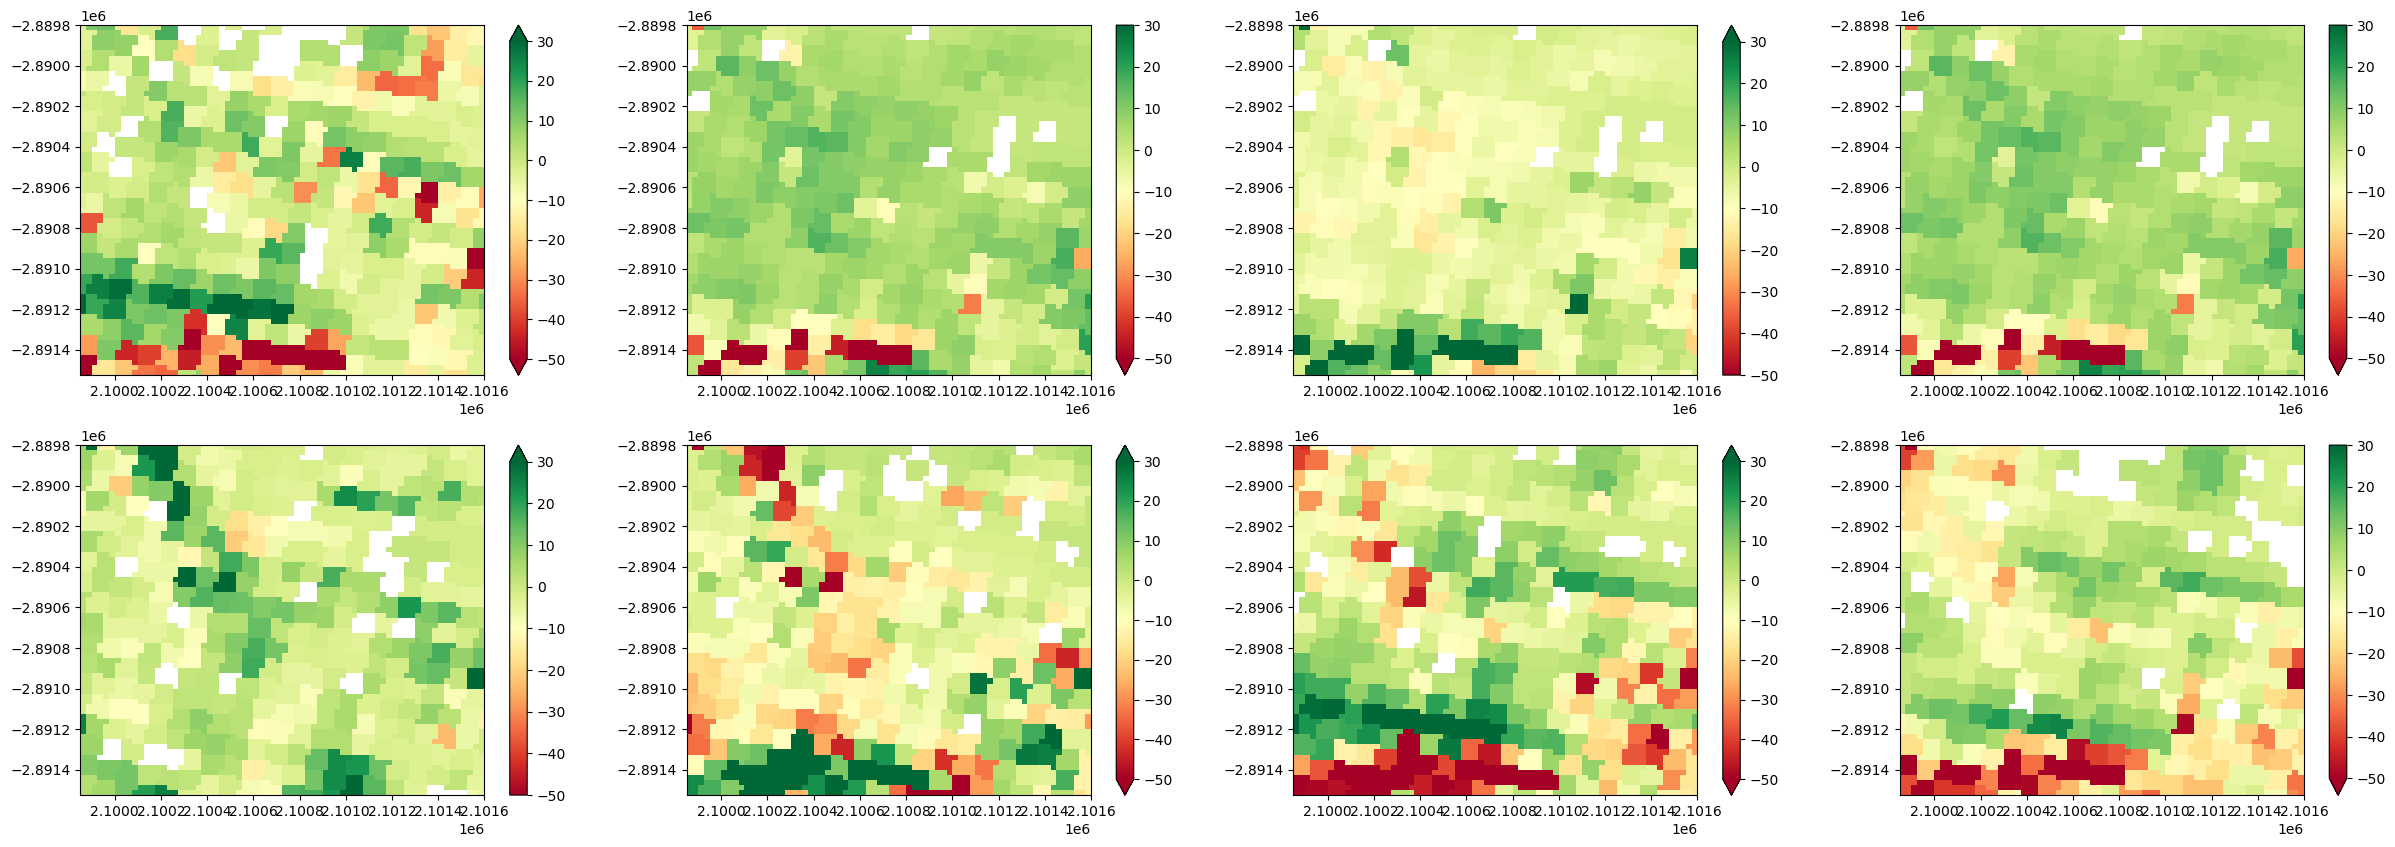

In [10]:
AGB_diff_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
diff_biomass.d2010_2020.plot(ax=axs[0,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2015_2016.plot(ax=axs[0,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2016_2017.plot(ax=axs[0,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2018.plot(ax=axs[0,3], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2018_2019.plot(ax=axs[1,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2019_2020.plot(ax=axs[1,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2020.plot(ax=axs[1,3], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)

In [11]:
#display_tools.display_da(AGB.AGB2017.where(AGB.AGB2017 != 0), colormap='terrain_r')
#display_tools.display_da.where((diff_biomass.d2010_2015<0), colormap='terrain_r')

In [13]:
biomass_masked_2010 = geopolygon_masking(AGB.AGB2010, geopolygon=selected_polygon)
biomass_masked_2015 = geopolygon_masking(AGB.AGB2015, geopolygon=selected_polygon)
biomass_masked_2016 = geopolygon_masking(AGB.AGB2016, geopolygon=selected_polygon)
biomass_masked_2017 = geopolygon_masking(AGB.AGB2017, geopolygon=selected_polygon)
biomass_masked_2018 = geopolygon_masking(AGB.AGB2018, geopolygon=selected_polygon)
biomass_masked_2019 = geopolygon_masking(AGB.AGB2019, geopolygon=selected_polygon)
biomass_masked_2020 = geopolygon_masking(AGB.AGB2020, geopolygon=selected_polygon)
biomass_masked_2021 = geopolygon_masking(AGB.AGB2021, geopolygon=selected_polygon)
#lc_dataset_masked = geopolygon_masking(lc_dataset, geopolygon=geom)

AttributeError: 'Polygon' object has no attribute 'crs'

In [ ]:
agb_ml = biomass_masked_2010.to_dataset(name="bm_2010") 
agb_ml["bm_2015"] = biomass_masked_2015
agb_ml["bm_2016"] = biomass_masked_2016
agb_ml["bm_2017"] = biomass_masked_2017
agb_ml["bm_2018"] = biomass_masked_2018
agb_ml["bm_2019"] = biomass_masked_2019
agb_ml["bm_2020"] = biomass_masked_2020
agb_ml["bm_2021"] = biomass_masked_2021

In [ ]:
agb_ml_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
agb_ml.bm_2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)
agb_ml.bm_2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 150, add_labels=False)

In [ ]:
biomass_masked_2010 = geopolygon_masking(AGB.AGB2010, geopolygon=geom)
biomass_masked_2015 = geopolygon_masking(AGB.AGB2010, geopolygon=geom)
biomass_masked_2016 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
biomass_masked_2017 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
biomass_masked_2018 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
biomass_masked_2019 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
biomass_masked_2020 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
biomass_masked_2021 = geopolygon_masking(diff_biomass.d2016_2017, geopolygon=geom)
#lc_dataset_masked = geopolygon_masking(lc_dataset, geopolygon=geom)

In [ ]:
agb_ml.bm2010_2020.plot()

In [ ]:
AGB_mk_fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 10))
agb_ml.bm2010_2020.plot(ax=axs[0,0], cmap='terrain')
agb_ml.bm2015_2016.plot(ax=axs[0,1], cmap='terrain')
agb_ml.bm2016_2017.plot(ax=axs[0,2], cmap='terrain')
agb_ml.bm2017_2018.plot(ax=axs[0,2], cmap='terrain')
agb_ml.bm2018_2019.plot(ax=axs[0,2], cmap='terrain')
agb_ml.bm2019_2020.plot(ax=axs[0,2], cmap='terrain')
agb_ml.bm2020_2021.plot(ax=axs[0,2], cmap='terrain')
agb_ml.bm2017_2020.plot(ax=axs[0,2], cmap='terrain')


In [ ]:
biomass_masked()

In [ ]:
display_selected_coordinates(selected_polygon)

In [ ]:
####  NEED TO BRING IN THE POLYGON
AGB_masked = AGB.odc.mask(poly=selected_polygon)

In [ ]:
labels = ['2010', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
colors = ['orange', 'orange','orange','orange','orange','orange','orange','orange',]

In [ ]:
timeseries_AGB = AGB_masked.drop("spatial_ref").to_dataframe()
timeseries_AGB.boxplot()

In [ ]:
# Load DEA Fractional Cover data from the datacube
#fc = dc.load(product='ga_ls_fc_3',
#            group_by='solar_day',
#            measurements=['bs', 'pv', 'npv', 'ue'],
#            like=lc,
#)
#
fc = dc.load(product='ga_ls_fc_3',
            group_by='solar_day',
            measurements=['bs', 'pv', 'npv', 'ue'],
            like = lc,
            dask_chunks={'x':1024,'y':1024},
)
fc

In [ ]:
fc.pv.plot()

In [ ]:
fc_through_time = fc[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', size=5)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

In [ ]:
fc_through_time_rs = fc_through_time.resample("1M").mean().interpolate(method="time").pv

In [ ]:
dict = fc_through_time.to.dict

In [ ]:
fcdict = xarray.to_dict(through_time='list', encoding=False)

In [ ]:
fcs = fc_through_time.resample("1W").mean().interpolate(method="time").pv

In [ ]:
fc_through_time = fc[['npv', 'pv', 'bs']].mean(dim=['x', 'y']).persist() 
plots = []
for i in (5, 10, 20, 40):
    plots.append(
        fc_through_time["npv"].rolling(time=i).mean().hvplot()
    )
  

In [ ]:
dea_tools.temporal.calculate_vector_stat(vec: data dim, stat: data dim -> target dim, window_size=365, step=10, target_dim=365, progress=None, window='hann')

In [ ]:
plots[0] * plots[1] * plots[2] * plots[3]  # "*" = overlay plots

In [ ]:
#fc_through_time = fc[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])
fc_through_time = fc[['npv', 'pv' 'bs']].mean(dim=['x', 'y'])
#fc_dict = DataArray.to_dict(fc_through_time, encoding=False)
#fc_rolling = fc_through_time.rolling(time=10, center=True).mean()
#fc_through_time["npv"] = fc_through_time["npv"].rolling(10).mean()
fc_through_time = fc[['npv', 'pv', 'bs']].mean(dim=['x', 'y']).persist()
#fc_through_time.to_array().plot.line(hue='variable', size=5)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)')
plt.xlabel('Years');

In [ ]:
fc_through_time_av = fc_through_time.rolling('2s').sum()

In [ ]:
timeseries_AGB.to_csv(f"timeseries_AGB.csv")

In [ ]:
fcpv = fc_through_time.pv.to_csv(f"timeseries_Fractions.csv")
fpcv.to_csv(f"timeseries_Fractions.csv")

## Change impacts and pressures

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Load the dataset from the specified relative path
file_path = 'Impacts and pressures Final without colours.xlsx'
df = pd.read_excel(file_path)

# Replace NaN values in 'Impact_ID' and 'Pressure_ID' columns with zeros
df['Impact_ID'] = df['Impact_ID'].fillna(0)
df['Pressure_ID'] = df['Pressure_ID'].fillna(0)

# Make sure that the IDs are integers to avoid the decimal point in the display
df['Impact_ID'] = df['Impact_ID'].astype(int)
df['Pressure_ID'] = df['Pressure_ID'].astype(int)

# Map each impact with its ID to pressures with their IDs
impact_to_pressures = {
    f"{row['Impacts']} ({row['Impact_ID']})": df[
        (df['Impacts'] == row['Impacts']) & 
        (df['Impact_ID'] == row['Impact_ID'])
    ][['Pressures', 'Pressure_ID']].apply(
        lambda x: f"{x['Pressures']} ({x['Pressure_ID']})", axis=1).unique().tolist()
    for _, row in df.drop_duplicates(subset=['Impacts', 'Impact_ID']).iterrows()
}

# Create a dictionary to map each identifier to its associated evidence with values
identifier_to_evidence = {}

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['Level3a_Ev', 'Level3b_Ev', 'Level3c_Ev', 'Level3d_Ev', 'Level3e_Ev', 'Level3f_Ev', 'Level3g_Ev']
lifeform_columns = ['Lifeforma_Ev', 'Lifeformb_Ev', 'Lifeformc_Ev', 'Lifeformd_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Function to clean and convert values to integers
def clean_value(value):
    try:
        return int(float(value))
    except (ValueError, TypeError):
        return None

for _, row in df.iterrows():
    identifier = row['Impact_ID'] * 1000 + row['Pressure_ID']
    
    evidence_with_values = {}
    
    # Collect Time Evidence
    evidence_with_values['Time_Evidence'] = []
    for col in time_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Time_Evidence'].append((col, value))
    
    # Collect Level3 Evidence
    evidence_with_values['Level3_Evidence'] = []
    for col in level3_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Level3_Evidence'].append((col, value))
    
    # Collect Lifeform Evidence
    evidence_with_values['Lifeform_Evidence'] = []
    for col in lifeform_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Lifeform_Evidence'].append((col, value))
    
    # Collect Water Evidence
    evidence_with_values['Water_Evidence'] = []
    for col in water_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Water_Evidence'].append((col, value))
    
    # Collect Biomass Evidence
    evidence_with_values['Biomass_Evidence'] = []
    for col in biomass_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Biomass_Evidence'].append((col, value))
    
    # Collect Individual Evidence
    evidence_with_values['Individual_Evidence'] = []
    for col in individual_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Individual_Evidence'].append((col, value))
    
    identifier_to_evidence[identifier] = evidence_with_values

# Create the dropdown widgets for impacts and pressures with IDs
impact_dropdown = widgets.Dropdown(
    options=[(impact, impact) for impact in impact_to_pressures.keys()],
    description='Impact:',
    value=None  # Start without a selection
)

pressure_dropdown = widgets.Dropdown(
    options=[('Please select an Impact first', '')],
    description='Pressure:',
    value=None  # Start without a selection
)

# Define the output widget for displaying the calculation result and evidence
output = widgets.Output()

# Define the function to update pressure dropdown based on selected impact
def on_impact_change(change):
    if change['new']:
        selected_impact = change['new']
        pressures = impact_to_pressures.get(selected_impact, [])
        pressure_dropdown.options = [(p, p) for p in pressures]
    else:
        pressure_dropdown.options = [('Please select an Impact first', '')]

# Define the function to display the selected impact and pressure
def display_selection(impact, pressure):
    with output:
        output.clear_output()
        if impact and pressure:
            impact_id = int(impact.split('(')[1].split(')')[0])
            pressure_id = int(pressure.split('(')[1].split(')')[0])
            identifier = impact_id * 1000 + pressure_id

            display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
            display(HTML(f'<strong>Selected Pressure:</strong> {pressure}'))
            display(HTML(f'<strong>Identifier:</strong> {identifier}'))
            
            if identifier in identifier_to_evidence:
                display(HTML('<strong>Evidence:</strong>'))
                evidence = identifier_to_evidence[identifier]
                for group, values in evidence.items():
                    if values:
                        display(HTML(f'<strong>{group.replace("_", " ")}:</strong>'))
                        for evidence_name, value in values:
                            display(HTML(f'- {evidence_name}: {value}'))
        elif impact:
            display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
            display(HTML('<strong>Please select a pressure.</strong>'))
        else:
            display(HTML('<strong>Please select an impact.</strong>'))

# Set up observation for changes in the impact dropdown
impact_dropdown.observe(on_impact_change, names='value')

# Set up interaction to display selections
widgets.interactive(display_selection, impact=impact_dropdown, pressure=pressure_dropdown)

# Arrange the widgets and the output display
display(widgets.VBox([impact_dropdown, pressure_dropdown, output]))


## Section 8 

In [ ]:
# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['Level3a_Ev', 'Level3b_Ev', 'Level3c_Ev', 'Level3d_Ev', 'Level3e_Ev', 'Level3f_Ev', 'Level3g_Ev']
lifeform_columns = ['Lifeforma_Ev', 'Lifeformb_Ev', 'Lifeformc_Ev', 'Lifeformd_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Function to extract evidence values from Section 7
def get_evidence_output():
    evidence_output = {}
    for col in level3_columns + lifeform_columns + water_columns + biomass_columns + individual_columns:
        evidence_output[col] = globals().get(col, None)
    return evidence_output

# Get the actual evidence output from Section 7
evidence_output = get_evidence_output()

# Ensure lc is defined (Section 5)
# Load data from the Datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Load actual data for level3, lifeform, water persistence changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
change_vals_l3 = (start_l3 * 1000) + end_l3

start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf

# Convert to datasets
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals_l3,
    coords=lc.level3[0].coords,
    dims=lc.level3[0].dims,
    name="observed change",
    attrs=lc.level3[0].attrs,
    fastpath=False,
).to_dataset(name="l3_2010_2020")

obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals_lf,
    coords=lc.lifeform[0].coords,
    dims=lc.lifeform[0].dims,
    name="observed change",
    attrs=lc.lifeform[0].attrs,
    fastpath=False,
).to_dataset(name="lf_2010_2020")

# Define function to create and display individual masks
def create_and_display_individual_masks(evidence_output):
    for key, value in evidence_output.items():
        if value is None:
            continue

        if key.startswith('Level3'):
            change = np.where((obs_change_l3_2010_2020.l3_2010_2020 == value), 1, 0)
            change_xr = xr.DataArray(
                data=change,
                coords=obs_change_l3_2010_2020.coords,
                dims=obs_change_l3_2010_2020.dims,
                name="Change",
                attrs=None
            )
            change_ds = change_xr.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds.Change.plot(ax=ax, cmap='Reds')
            ax.set_title(f"Level3 Change Mask for {key} Value {value}")
            plt.show()
        
        elif key.startswith('Lifeform'):
            change = np.where((obs_change_lf_2010_2020.lf_2010_2020 == value), 1, 0)
            change_xr = xr.DataArray(
                data=change,
                coords=obs_change_lf_2010_2020.coords,
                dims=obs_change_lf_2010_2020.dims,
                name="Change",
                attrs=None
            )
            change_ds = change_xr.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds.Change.plot(ax=ax, cmap='Blues')
            ax.set_title(f"Lifeform Change Mask for {key} Value {value}")
            plt.show()

# Call the function to create and display the masks
create_and_display_individual_masks(evidence_output)


In [ ]:
# Ensure actual data loading is in place of random data

# Load actual data for level3 and lifeform changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
ignore_no_change = False
change_vals_l3 = (start_l3 * 1000) + end_l3
if ignore_no_change:
    change_vals_l3 = np.where(start_l3 == end_l3, 0, change_vals_l3)
level_3 = lc.level3[0].drop_vars("time")

obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals_l3,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

# Load actual data for lifeform changes
start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf
if ignore_no_change:
    change_vals_lf = np.where(start_lf == end_lf, 0, change_vals_lf)
lifeform = lc.lifeform[0].drop_vars("time")

obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals_lf,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")
del obs_change_lf_2010_2020

# Define selected values (example values, replace with actual user inputs)
selected_level3_values = [111111, 112112]  # Example values
selected_lifeform_values = [10, 20, 12]    # Example values

# Function to create and display individual masks
def create_and_display_individual_masks():
    global selected_level3_values, selected_lifeform_values

    # Debug: Print selected values
    print(f"Selected Level3 Values: {selected_level3_values}")
    print(f"Selected Lifeform Values: {selected_lifeform_values}")

    if selected_level3_values:
        # Create and plot individual masks for each Level3 value
        for lvl3_val in selected_level3_values:
            change_l3 = np.where(
                (obs_change_l3.l3_2010_2020 == lvl3_val),
                1,
                0
            )

            change_xr_l3 = xr.DataArray(
                data=change_l3,
                coords=obs_change_l3.coords,
                dims=obs_change_l3.dims,
                name="Change",
                attrs=None
            )

            change_ds_l3 = change_xr_l3.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_l3.Change.plot(ax=ax, cmap='Reds')
            ax.set_title(f"Level3 Change Mask for Value {lvl3_val}")
            plt.show()
    
    if selected_lifeform_values:
        # Create and plot individual masks for each Lifeform value
        for lf_val in selected_lifeform_values:
            change_lf = np.where(
                (obs_change_lf.lf_2010_2020 == lf_val),
                1,
                0
            )

            change_xr_lf = xr.DataArray(
                data=change_lf,
                coords=obs_change_lf.coords,
                dims=obs_change_lf.dims,
                name="Change",
                attrs=None
            )

            change_ds_lf = change_xr_lf.where(change_xr_lf != 0).to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_lf.Change.plot(ax=ax, cmap='Blues')
            ax.set_title(f"Lifeform Change Mask for Value {lf_val}")
            plt.show()

# Call the function to create and display the masks
#create_and_display_individual_masks()
#display_tools.display_da(obs_change_lf.lf_2010_2020.where(obs_change_lf.lf_2010_2020 == 20), colormap='terrain_r')
#display_tools.display_da(obs_change_l3.l3_2010_2020.where(obs_change_l3.l3_2010_2020 == 112215), colormap='terrain_r')
#display_tools.display_da(obs_change_l3.l3_2010_2020.where((obs_change_l3.l3_2010_2020 == 124112)|(obs_change_l3.l3_2010_2020 == 124124)), colormap='terrain_r')
display_tools.display_da(obs_change_l3.l3_2010_2020.where((obs_change_l3.l3_2010_2020 == 124124)&(diff_biomass.d2010_2015>0)), colormap='terrain_r')
#display_tools.display_da(obs_change_l3.l3_2010_2020.where((obs_change_l3.l3_2010_2020 == 124220)), colormap='terrain_r')

In [ ]:
# Function to create and display the mask
def create_and_display_mask():
    global selected_level3a_value, selected_level3b_value,selected_level3c_value, selected_level3d_value, selected_level3e_value, selected_level3f_value, selected_level3g_value,\
    selected_lifeforma_value, selected_lifeformb_value, selected_lifeformc_value, selected_lifeformd_value, selected_agb_value, selected_agbsd_value,\
    selected_waterpera_value, selected_waterperb_value, selected_waterperc_value, selected_waterperd_value, selected_waterpere_value, selected_waterperf_value

    # Debug: Print selected values
    print(f"Selected Level3a Value: {selected_level3a_value}")
    print(f"Selected Level3b Value: {selected_level3b_value}")
    print(f"Selected Level3c Value: {selected_level3c_value}")
    print(f"Selected Level3d Value: {selected_level3d_value}")
    print(f"Selected Level3e Value: {selected_level3e_value}")
    print(f"Selected Level3f Value: {selected_level3f_value}")
    print(f"Selected Level3g Value: {selected_level3g_value}")          
    print(f"Selected Lifeforma Value: {selected_lifeforma_value}")
    print(f"Selected Lifeformb Value: {selected_lifeformb_value}")
    print(f"Selected Lifeformc Value: {selected_lifeformc_value}")
    print(f"Selected Lifeformd Value: {selected_lifeformd_value}")
    print(f"Selected AGB Value: {selected_agb_value}")
    print(f"Selected AGBSD Value: {selected_agbsd_value}")
    print(f"Selected Waterpera Value: {selected_waterpera_value}")
    print(f"Selected Waterperb Value: {selected_waterperb_value}")
    print(f"Selected Waterpera Value: {selected_waterperc_value}")
    print(f"Selected Waterperb Value: {selected_waterperd_value}")
    print(f"Selected Waterpera Value: {selected_waterpere_value}")
    print(f"Selected Waterperb Value: {selected_waterperf_value}")


#    if selected_level3a_value is not 0 and selected_level3b_value is not 0 and selected_level3c_value is not 0 and selected_level3d_value is not 0 and selected_level3e_value is not 0 and selected_level3f_value is not 0 and selected_level3g_value is not 0 and selected_lifeforma_value is not 0 and selected_lifeformb_value is not 0 and selected_waterpera_value is not 0 and selected_waterpera_value is not 0 and selected_waterperb_value is not 0 and selected_waterperc_value is not 0 and selected_waterperd_value is not 0 and selected_waterpere_value is not 0 and selected_waterperf_value is not 0:
    if selected_level3a_value is not 0:

# Make a mask of 1 for the selected impact and lifeform class
        change = np.where(
# Level 3 changes
            (((obs_change_l3.l3_2010_2020 == selected_level3a_value)&(obs_change_l3.l3_2010_2020 > 0))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3b_value) &(obs_change_l3.l3_2010_2020 > 0))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3c_value) &(obs_change_l3.l3_2010_2020 > 0))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3d_value) &(obs_change_l3.l3_2010_2020 > 0))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3e_value) &(obs_change_l3.l3_2010_2020 > 0))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3f_value) &(obs_change_l3.l3_2010_2020 > 0)))|\
            ((obs_change_l3.l3_2010_2020 == selected_level3g_value)) & 
#
# Lifeform changes
#
            (((obs_change_lf.lf_2010_2020 == selected_lifeforma_value)&(obs_change_lf.lf_2010_2020 > 0))|\
            ((obs_change_lf.lf_2010_2020 == selected_lifeformb_value) &(obs_change_lf.lf_2010_2020 > 0))|\
            ((obs_change_lf.lf_2010_2020 == selected_lifeformc_value) &(obs_change_lf.lf_2010_2020 > 0))|\
            ((obs_change_lf.lf_2010_2020 == selected_lifeformd_value) &(obs_change_lf.lf_2010_2020 > 0))) &
#
# Lifeform changes
#
            (diff_biomass.d2017_2018 < 0) &
#            (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1) &
#
# Water persistence changes
#
            (((obs_change_wp.wp_2010_2020 == selected_waterpera_value)&(obs_change_wp.wp_2010_2020 > 0))|\
            ((obs_change_wp.wp_2010_2020 == selected_waterperb_value) &(obs_change_wp.wp_2010_2020 > 0))|\
            ((obs_change_wp.wp_2010_2020 == selected_waterperc_value) &(obs_change_wp.wp_2010_2020 > 0))|\
            ((obs_change_wp.wp_2010_2020 == selected_waterperd_value) &(obs_change_wp.wp_2010_2020 > 0))|\
            ((obs_change_wp.wp_2010_2020 == selected_waterpere_value) &(obs_change_wp.wp_2010_2020 > 0))|\
            ((obs_change_wp.wp_2010_2020 == selected_waterperf_value) &(obs_change_wp.wp_2010_2020 > 0))),

            1,
            0
        )

# Convert the mask to an xarray DataArray
        change_xr = xr.DataArray(
            data=change,
            coords=obs_change_l3.coords,
            dims=obs_change_l3.dims,
            name="Change",
            attrs=None
        )  
    
# Convert to dataset
        change_ds = change_xr.to_dataset(name="Change")
        
        # Plot the results
        change_fig, axs = plt.subplots(figsize=(20, 8), ncols=2)
        change_ds.Change.plot(ax=axs[0], cmap=cmap)
        plt.show()
        
    else:
        print("Please select valid Level3, Lifeform and/or Water peristence values.")

# Call the function to create and display the mask
create_and_display_mask()

In [ ]:
display_tools.display_da(obs_change_l3[0], colormap='magma_r')